In [1]:
from utils import *
from plotting import create_plot, create_dual_plot, boxplot_comparison

In [2]:
top5_same = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.0035_1%I_top5_with_0s_only_matching.tsv", sep='\t')
top5_same.rename(columns={'CosineHungarian_0.0035_0.0_1.0_scores': 'scores'}, inplace=True)
top5_same.rename(columns={'CosineHungarian_0.0035_0.0_1.0_matches': 'matches'}, inplace=True)
merged_top5_same = normalize_df(append_classes(top5_same, 'query'), matches_norm_col=None)

merged_top5_same_N = merged_top5_same.copy()

# exclude nitrigen
merged_top5_same = merged_top5_same[merged_top5_same['N'] != True]

# Apply the function to each row of the DataFrame
merged_top5_same_N['true_names'] = merged_top5_same_N.apply(lambda row: get_true_names(row, merged_top5_same_N), axis=1)
merged_top5_same['true_names'] = merged_top5_same.apply(lambda row: get_true_names(row, merged_top5_same), axis=1)

# Convert the list of names to a comma-separated string
merged_top5_same_N['true_names'] = merged_top5_same_N['true_names'].apply(lambda lst: ', '.join(lst))
merged_top5_same['true_names'] = merged_top5_same['true_names'].apply(lambda lst: ', '.join(lst))

In [3]:
mdf = preprocess_data(merged_top5_same, ["true_names"])
mdf_N = preprocess_data(merged_top5_same_N, ["true_names"])

In [4]:
mdf = clean_chemical_composition_data(mdf)
mdf_N = clean_chemical_composition_data(mdf_N)

/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)
/tmp/ipykernel_13717/3981138082.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mdf_p1['true_names'].replace(to_replace="C,O,N,H", value="C,O,H", inplace=True)
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: Use

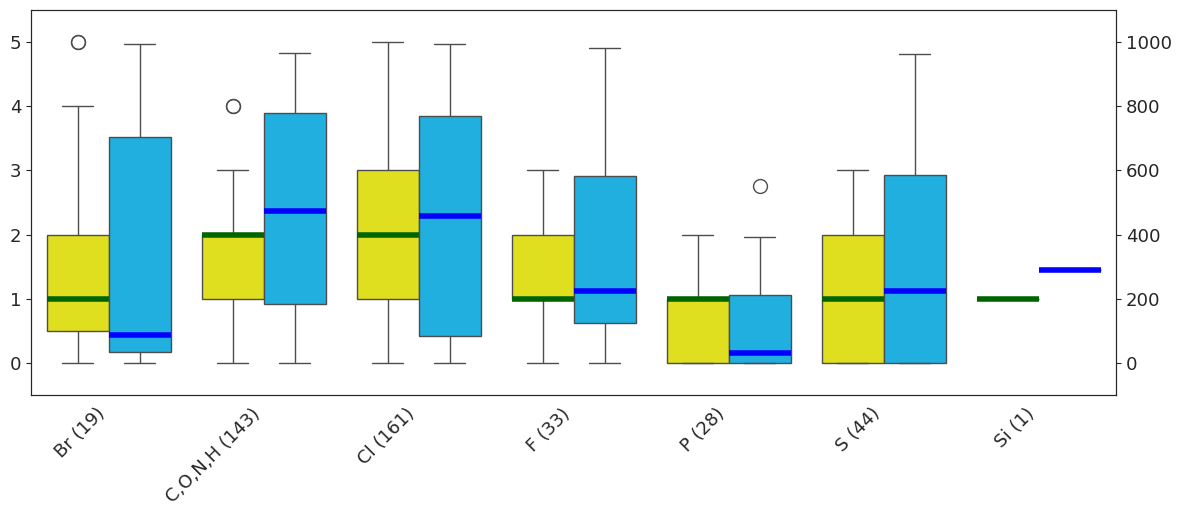

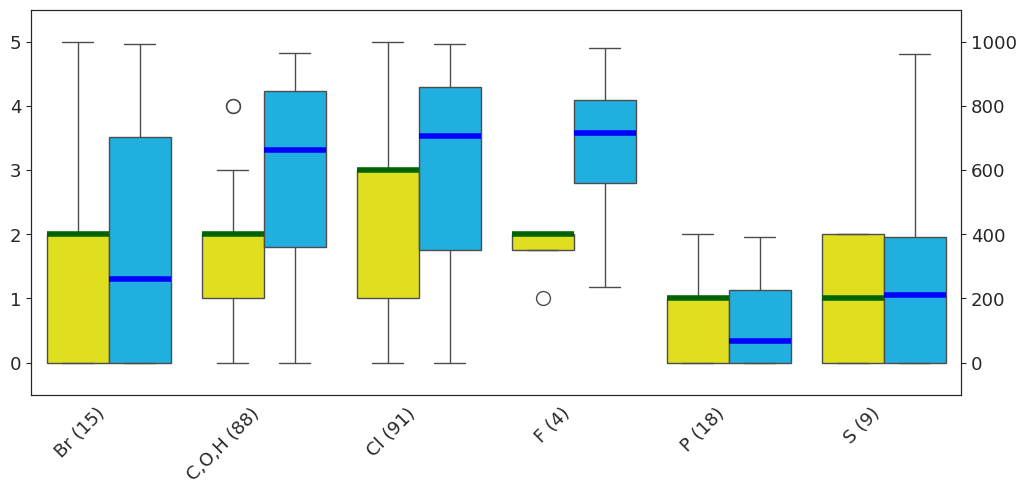

In [5]:
# with Nitrogen plot 1
mdf_N_p1 = split_and_add_rows(mdf_N, 'true_names', split_by=', ')
mdf_N_p1 = mdf_N_p1.sort_values(by=['true_names'])

create_plot(mdf_N_p1, "true_names", None, normalized_matches=False, hide_labels=True, showlegend=False).show()

# without Nitrogen plot 1
mdf_p1 = split_and_add_rows(mdf, 'true_names', split_by=', ')
mdf_p1 = mdf_p1.sort_values(by=['true_names'])
mdf_p1['true_names'].replace(to_replace="C,O,N,H", value="C,O,H", inplace=True)

create_plot(mdf_p1, "true_names", None, normalized_matches=False, hide_labels=True, showlegend=False).show()

/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)


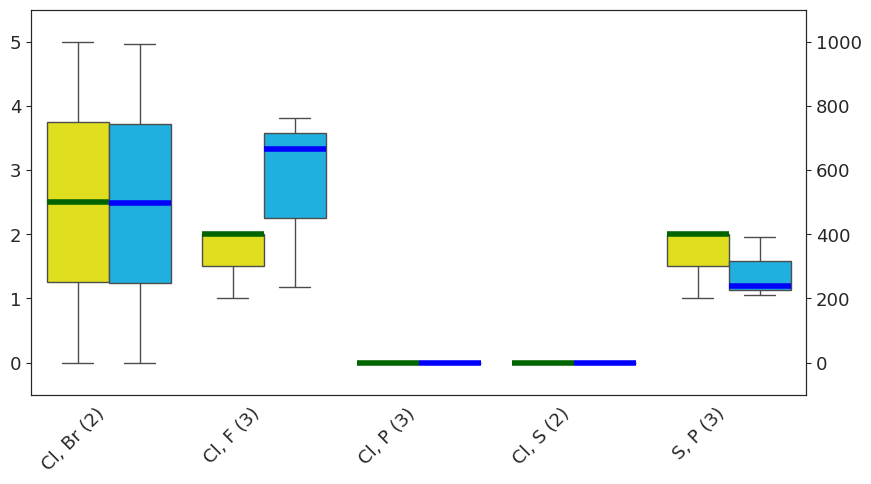

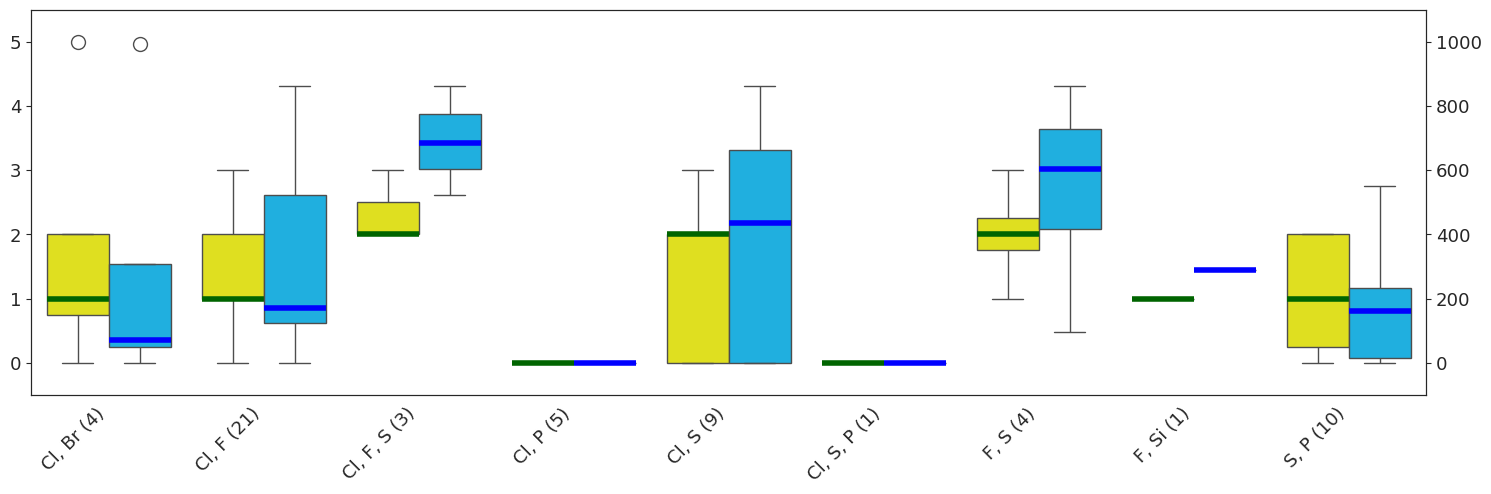

In [6]:
# without Nitrogen plot 2
mdf_p2 = generate_combinations(mdf, 'true_names')
mdf_p2 = mdf_p2.sort_values(by=['true_names'])

create_plot(mdf_p2, "true_names", None, normalized_matches=None, nist_scale=True, hide_labels=True, showlegend=False).show()

# with Nitrogen plot 2
mdf_N_p2 = generate_combinations(mdf_N, 'true_names')
mdf_N_p2 = mdf_N_p2.sort_values(by=['true_names'])

create_plot(mdf_N_p2, "true_names", None, normalized_matches=None, nist_scale=True, hide_labels=True, showlegend=False).show()

In [7]:

all_same = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.0035_1%I_all_peaks_with_0s_only_matching.tsv", sep='\t')
all_same.rename(columns={'CosineHungarian_0.0035_0.0_1.0_scores': 'scores'}, inplace=True)
all_same.rename(columns={'CosineHungarian_0.0035_0.0_1.0_matches': 'matches'}, inplace=True)
merged_all_same = normalize_df(append_spectrum_metadata(append_classes(all_same, 'query')))

merged_all_same_N = merged_all_same.copy()

# exclude nitrigen
merged_all_same = merged_all_same[merged_all_same['N'] != True]

# Apply the function to each row of the DataFrame
merged_all_same_N['true_names'] = merged_all_same_N.apply(lambda row: get_true_names(row, merged_all_same_N), axis=1)
merged_all_same['true_names'] = merged_all_same.apply(lambda row: get_true_names(row, merged_all_same), axis=1)

# Convert the list of names to a comma-separated string
merged_all_same_N['true_names'] = merged_all_same_N['true_names'].apply(lambda lst: ', '.join(lst))
merged_all_same['true_names'] = merged_all_same['true_names'].apply(lambda lst: ', '.join(lst))

In [8]:
mdf_all = preprocess_data(merged_all_same, ["true_names"])
mdf_N_all = preprocess_data(merged_all_same_N, ["true_names"])
mdf_all = clean_chemical_composition_data(mdf_all)
mdf_N_all = clean_chemical_composition_data(mdf_N_all)

/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)
/tmp/ipykernel_13717/3490255631.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=

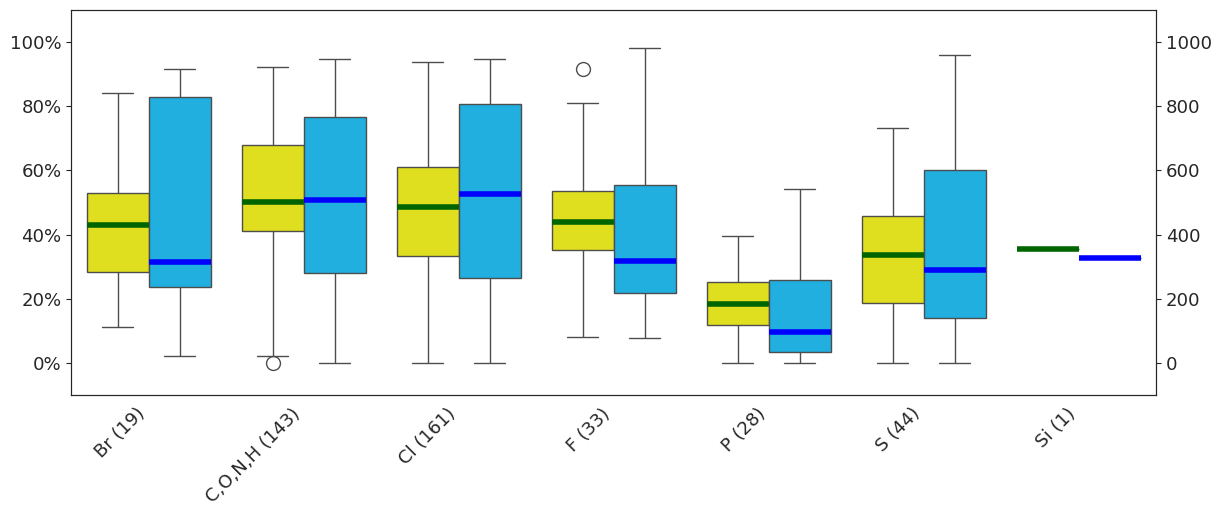

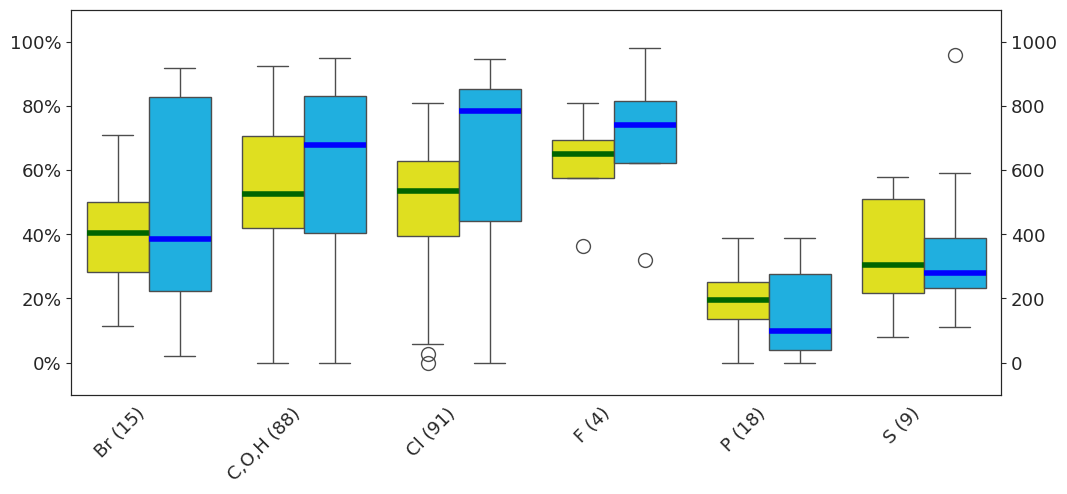

In [9]:
# with Nitrogen plot 1
mdf_N_p1_all = split_and_add_rows(mdf_N_all, 'true_names', split_by=', ')
mdf_N_p1_all = mdf_N_p1_all.sort_values(by=['true_names'])

create_plot(mdf_N_p1_all, "true_names", None, showlegend=False, hide_labels=True).show()

# without Nitrogen plot 1
mdf_p1_all = split_and_add_rows(mdf_all, 'true_names', split_by=', ')
mdf_p1_all = mdf_p1_all.sort_values(by=['true_names'])
mdf_p1_all['true_names'].replace(to_replace="C,O,N,H", value="C,O,H", inplace=True)

create_plot(mdf_p1_all, "true_names", None, showlegend=False, hide_labels=True).show()

/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fix

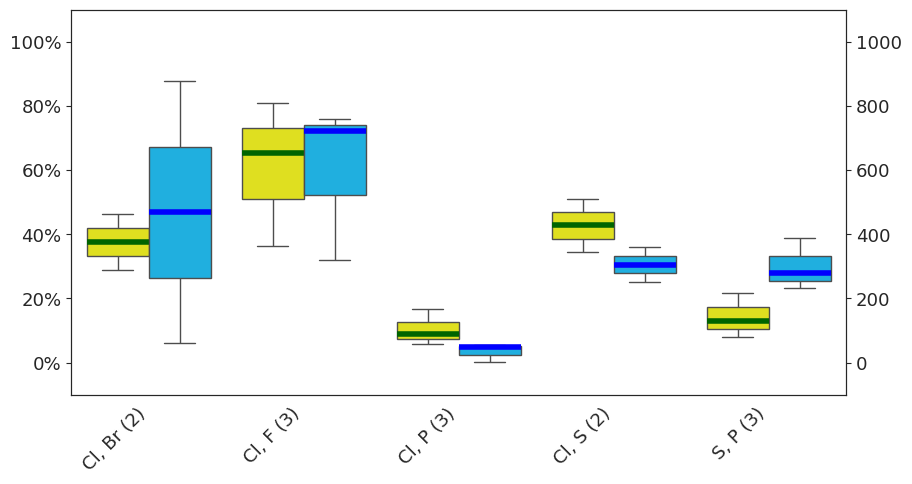

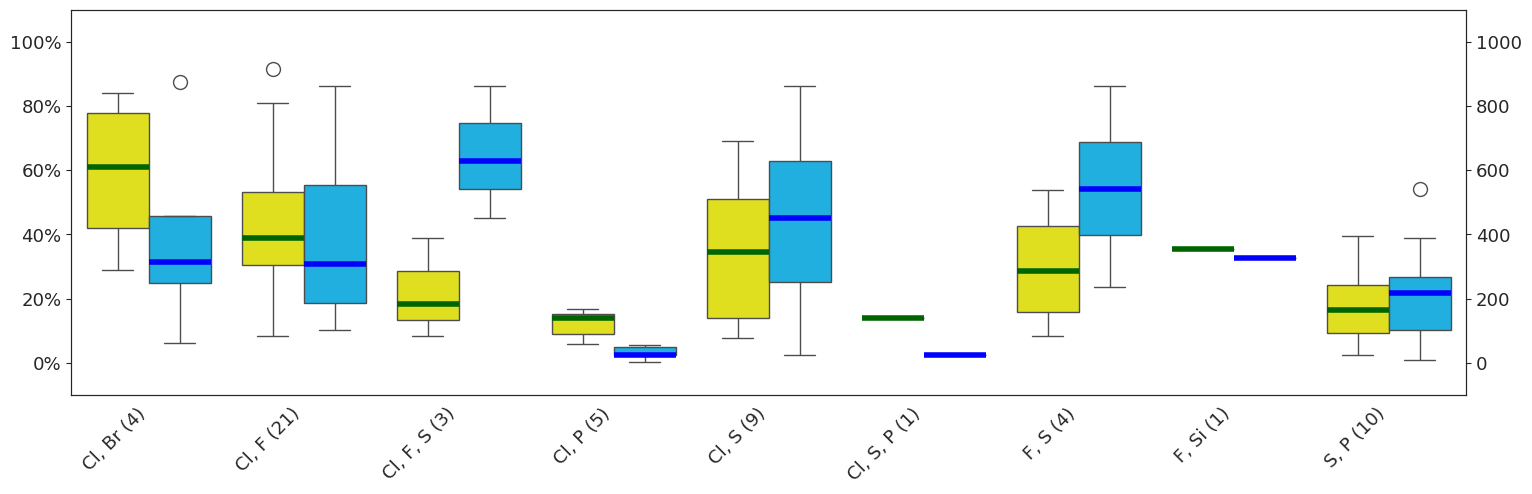

In [10]:
# without Nitrogen plot 2
mdf_p2_all = generate_combinations(mdf_all, 'true_names')
mdf_p2_all = mdf_p2_all.sort_values(by=['true_names'])

create_plot(mdf_p2_all, "true_names", None, showlegend=False, hide_labels=True).show()

# with Nitrogen plot 2
mdf_N_p2_all = generate_combinations(mdf_N_all, 'true_names')
mdf_N_p2_all = mdf_N_p2_all.sort_values(by=['true_names'])

create_plot(mdf_N_p2_all, "true_names", None, showlegend=False, hide_labels=True).show()

In [11]:
all_peaks_same = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.0035_1%I_all_peaks_with_0s_only_matching.tsv", sep='\t')
all_peaks_same.rename(columns={'CosineHungarian_0.0035_0.0_1.0_scores': 'scores'}, inplace=True)
all_peaks_same.rename(columns={'CosineHungarian_0.0035_0.0_1.0_matches': 'matches'}, inplace=True)
all_peaks_same = append_spectrum_metadata(all_peaks_same)
merged_all_peaks_same = normalize_df(append_classes(all_peaks_same, 'query'))
mdf_comp = preprocess_data(merged_all_peaks_same, ["composition"])

/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)


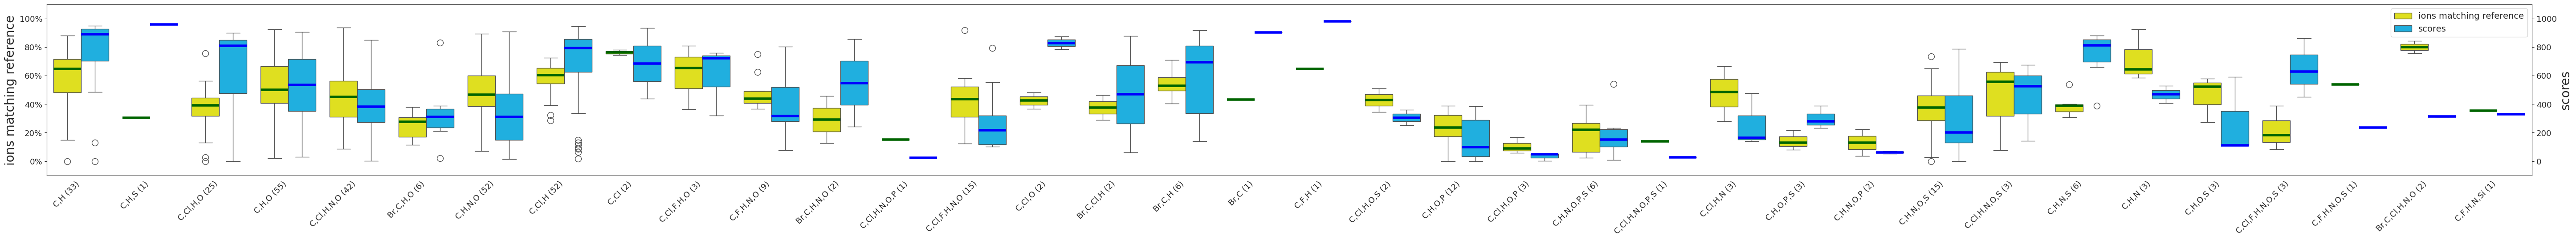

In [12]:
create_plot(mdf_comp, "composition").show()

/tmp/ipykernel_13717/2429072291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf_comp_baseline.sort_index(axis=1, inplace=True)
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)


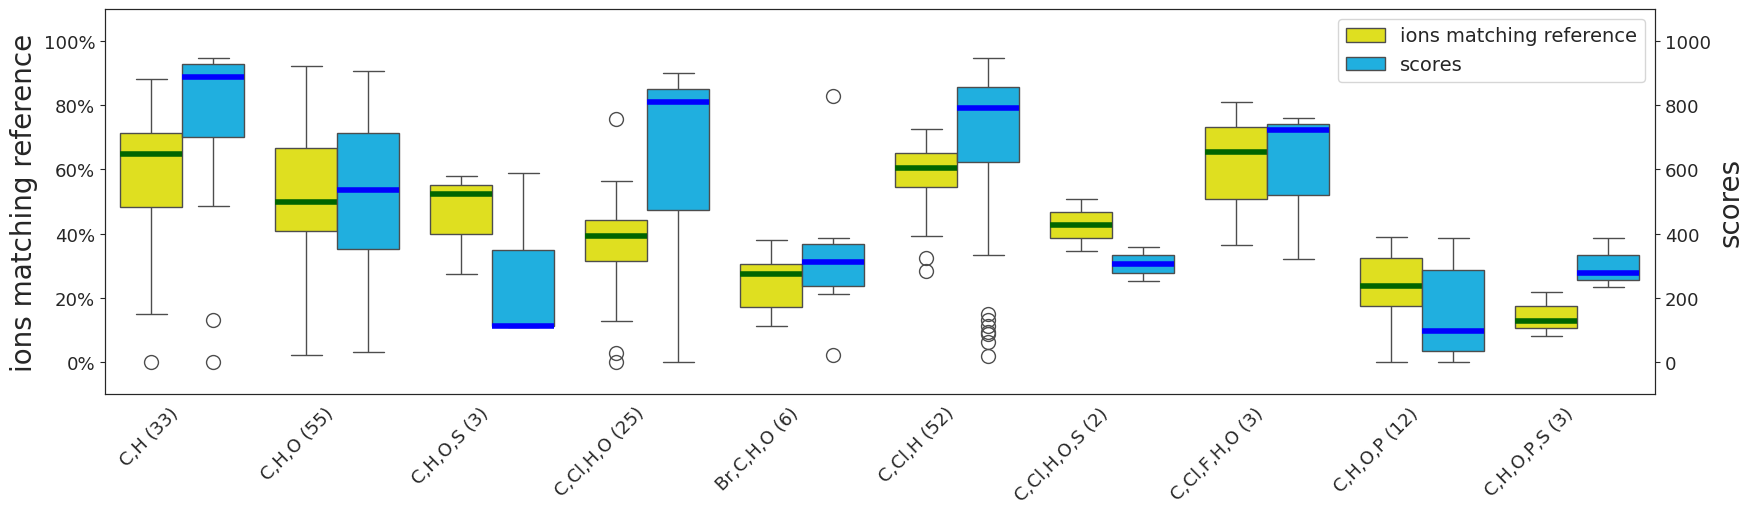

In [13]:
baseline_cols= ['C,H', 'C,H,O', 'C,H,O,S', 'C,Cl,H,O', 'Br,C,H,O', 'C,Cl,H', 'C,Cl,H,O,S', 'C,Cl,F,H,O', 'C,H,O,P', 'C,H,O,P,S']
mdf_comp_baseline = mdf_comp.loc[mdf_comp['composition'].isin(baseline_cols)]
mdf_comp_baseline.sort_index(axis=1, inplace=True)
create_plot(mdf_comp_baseline, "composition", order=baseline_cols).show()


/tmp/ipykernel_13717/2466962757.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf_comp_nitrogen.sort_index(axis=1, inplace=True)
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)


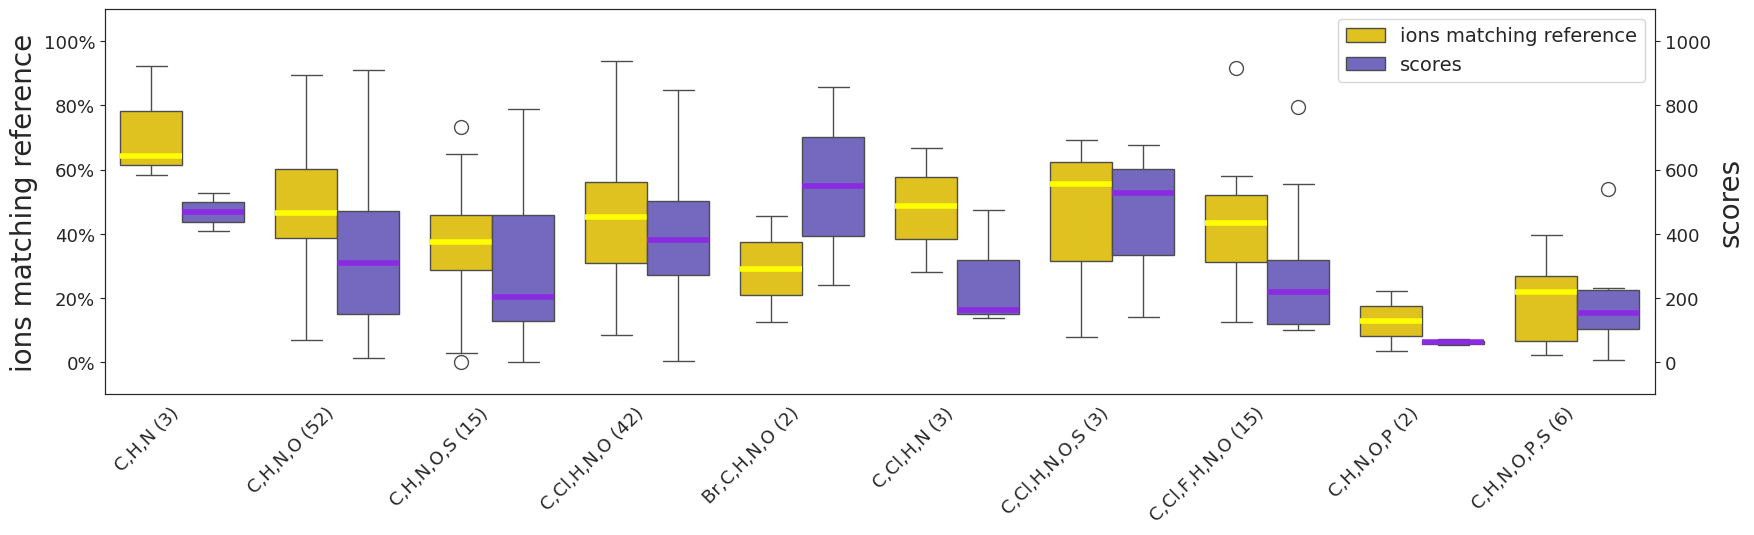

In [14]:
nitrogen_cols = ['C,H,N', 'C,H,N,O','C,H,N,O,S', 'C,Cl,H,N,O', 'Br,C,H,N,O', 'C,Cl,H,N', 'C,Cl,H,N,O,S', 'C,Cl,F,H,N,O','C,H,N,O,P', 'C,H,N,O,P,S']
mdf_comp_nitrogen = mdf_comp.loc[mdf_comp['composition'].isin(nitrogen_cols)]
mdf_comp_nitrogen.sort_index(axis=1, inplace=True)
create_plot(mdf_comp_nitrogen, "composition", order=nitrogen_cols, colors=["gold", "slateblue"], median_colors = ['yellow', 'blueviolet']).show()

/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fix

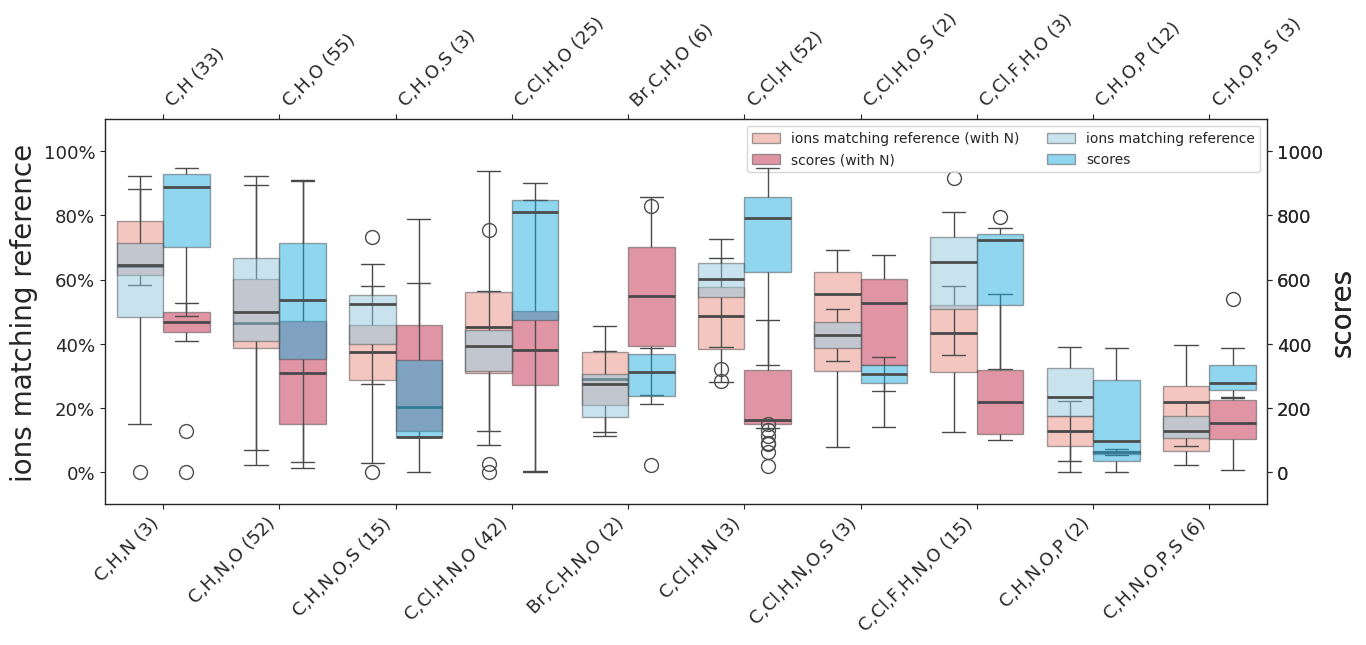

In [15]:
create_dual_plot(
    mdf_comp_nitrogen,
    mdf_comp_baseline,
    "composition",
    order1=nitrogen_cols,
    order2=baseline_cols
).show()

/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)


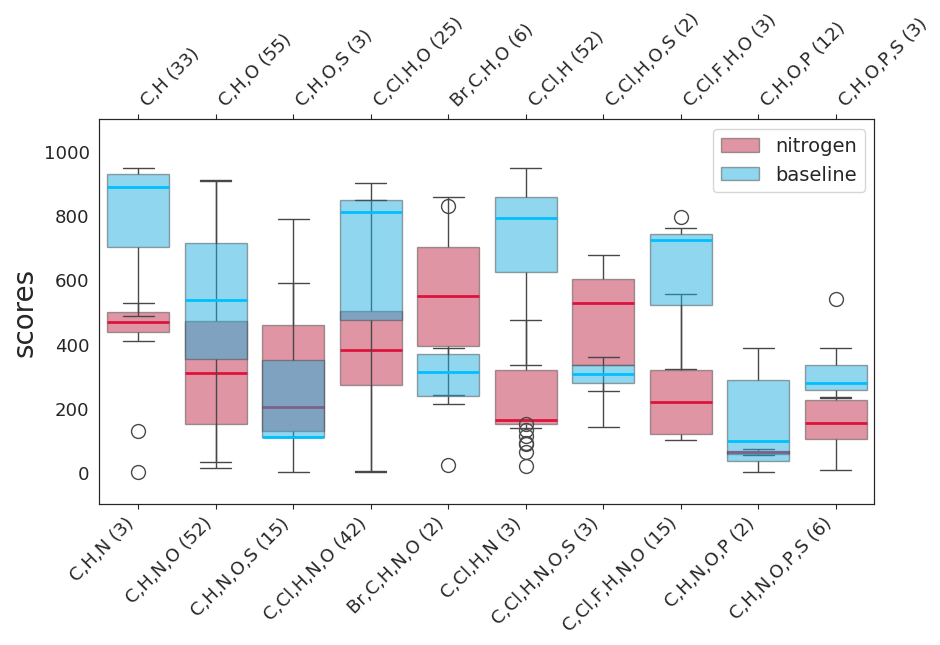

In [16]:
boxplot_comparison(
    mdf_comp_baseline,
    baseline_cols,
    mdf_comp_nitrogen,
    nitrogen_cols,
    'scores',
    colors=['crimson', 'deepskyblue']
).show()

/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fix

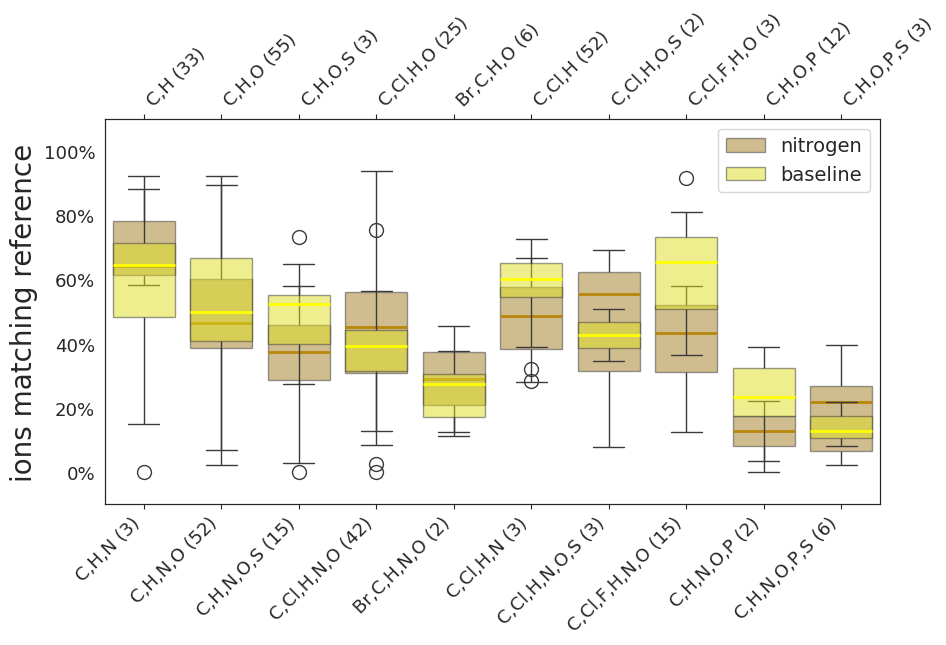

In [17]:
boxplot_comparison(
    mdf_comp_baseline,
    baseline_cols,
    mdf_comp_nitrogen,
    nitrogen_cols,
    'matches',
    colors=["darkgoldenrod", "yellow"],
).show()

/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)


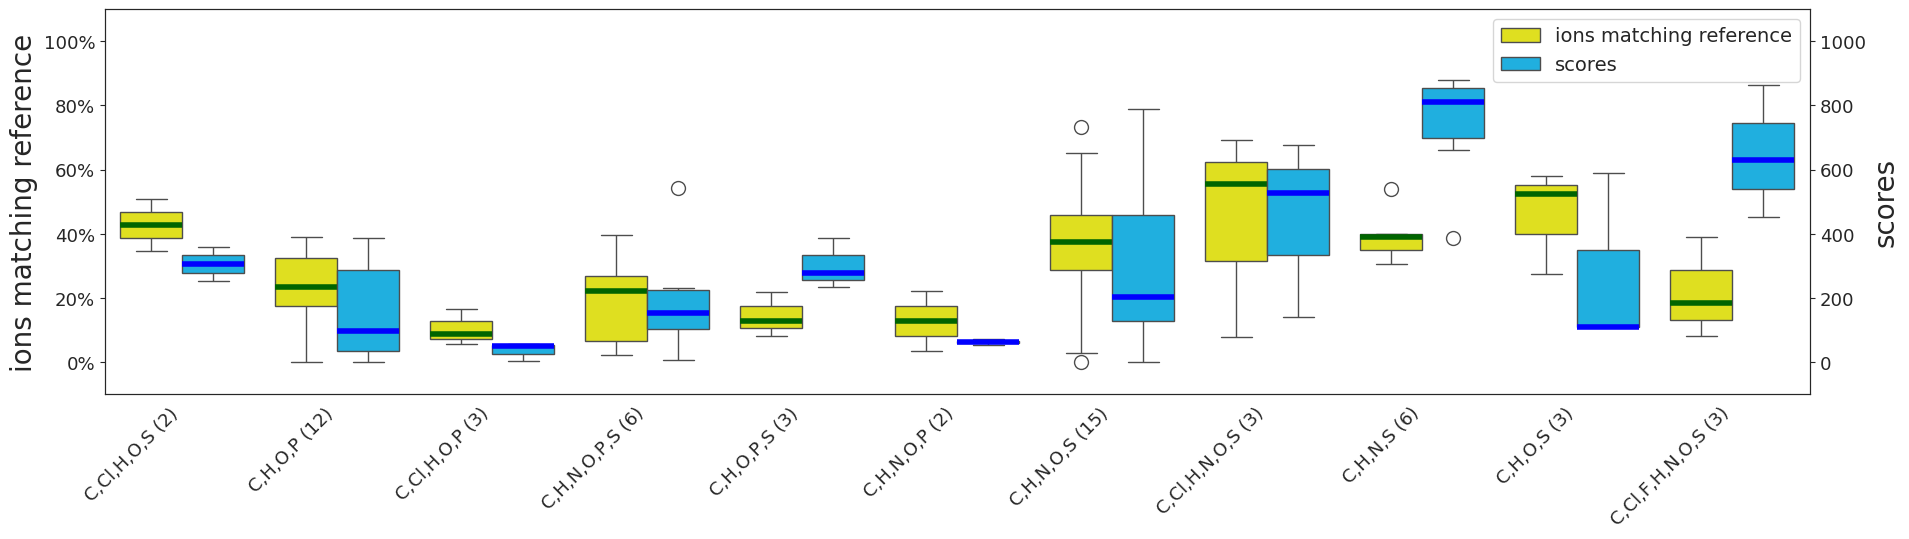

In [18]:
mdf_comp_ps = mdf_comp[mdf_comp['composition'].str.contains('S|P')]
mdf_comp_ps = mdf_comp_ps[mdf_comp_ps['composition'] != 'C,F,H,N,Si']
mdf_comp_ps = mdf_comp_ps.groupby('composition').filter(lambda x: len(x) > 2)
create_plot(mdf_comp_ps, "composition").show()


/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fix

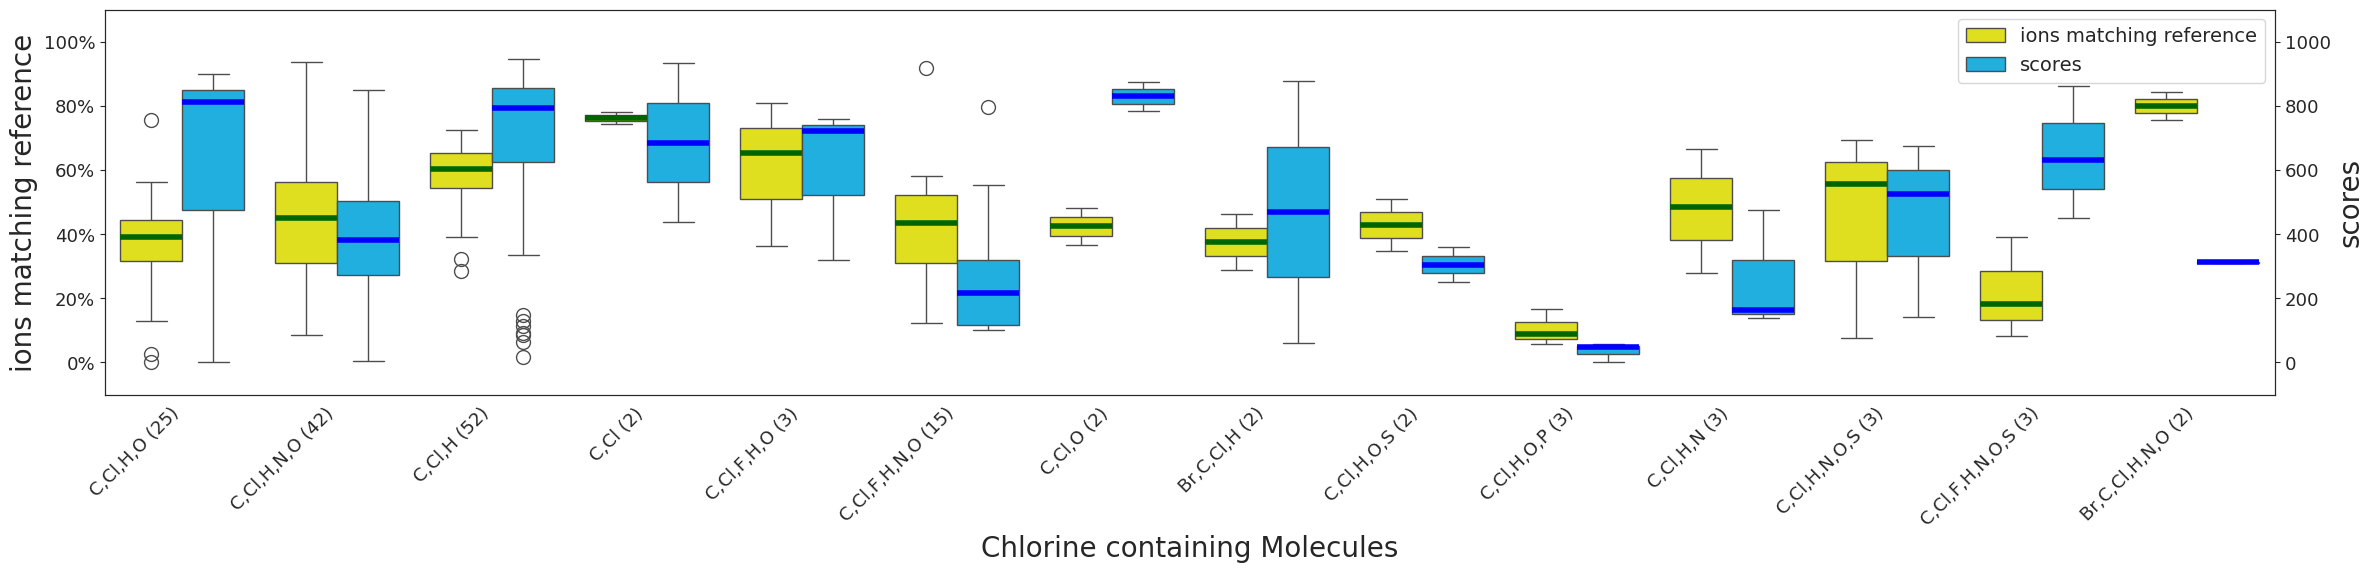

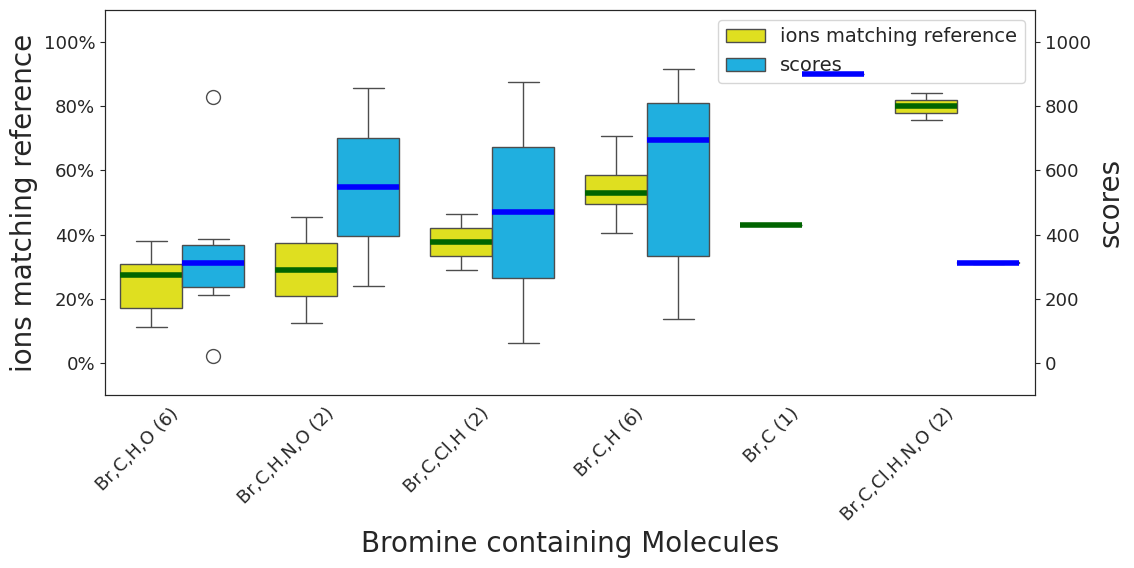

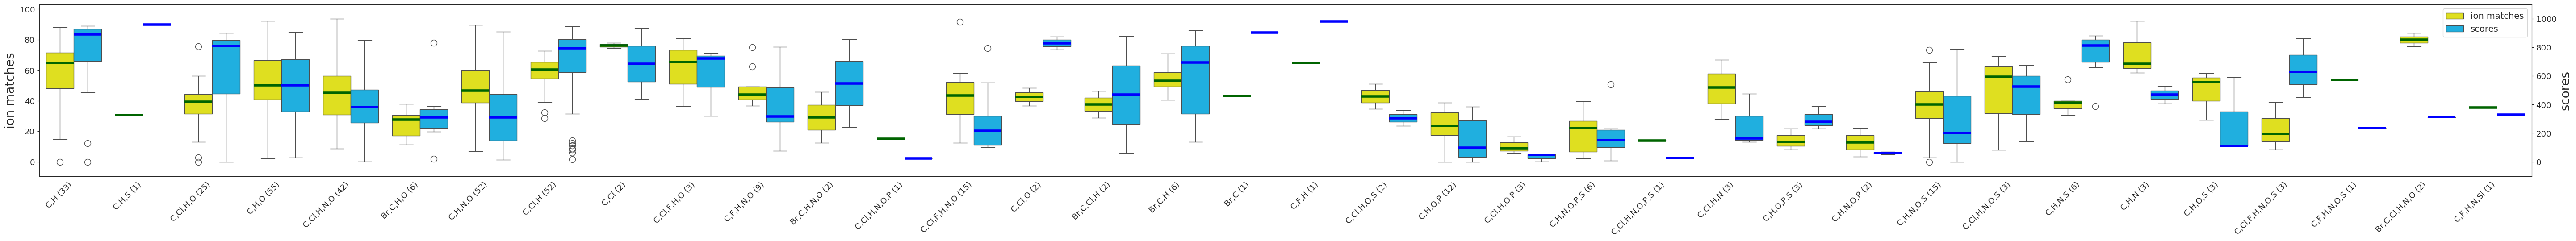

In [19]:
mdf_comp_halogen = mdf_comp[mdf_comp['composition'].str.contains('Cl|Br|F|I')]
mdf_comp_chlorinated = mdf_comp[mdf_comp['composition'].str.contains('Cl')]
mdf_comp_chlorinated = mdf_comp_chlorinated.groupby('composition').filter(lambda x: len(x) > 2)

mdf_comp_brominated = mdf_comp[mdf_comp['composition'].str.contains('Br')]
mdf_comp_organic = mdf_comp.loc[mdf_comp['composition'].isin(['C,H', 'C,H,O', 'C,H,N', 'C,H,N,O'])]

# create_plot(mdf_comp_halogen, "composition", "Halogen containing Molecules").show()
create_plot(mdf_comp_chlorinated, "composition", "Chlorine containing Molecules").show()
create_plot(mdf_comp_brominated, "composition", "Bromine containing Molecules").show()
# create_plot(mdf_comp_organic, "composition", "Organic Molecules", normalized_matches=False).show()
create_plot(mdf_comp, "composition", normalized_matches=False).show()

/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)


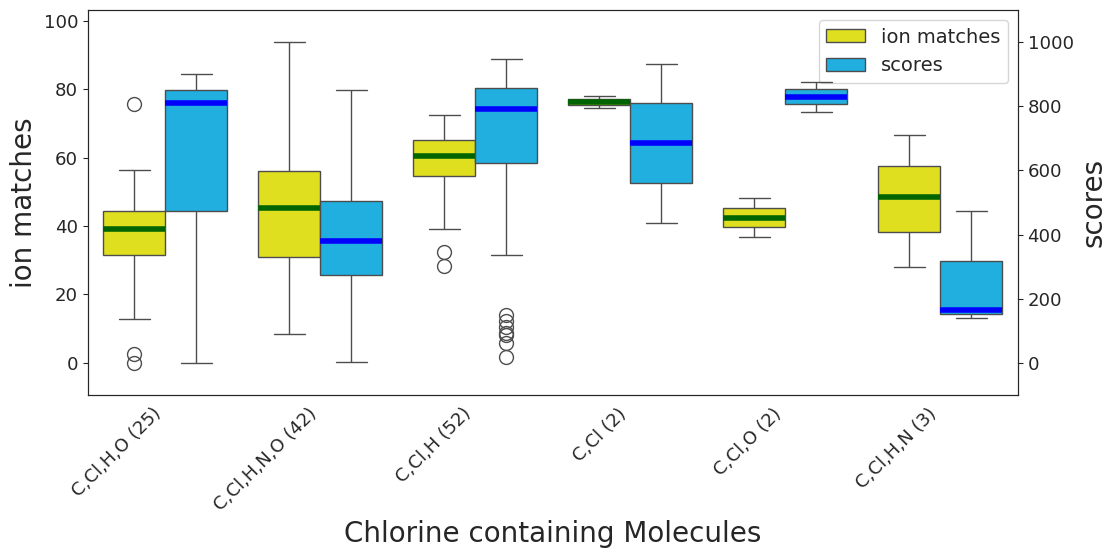

In [20]:
mdf_comp_chlorinated = mdf_comp[mdf_comp['composition'].str.contains('Cl') & ~mdf_comp['composition'].str.contains('Br|F|I|P|S|Si')]
create_plot(mdf_comp_chlorinated, "composition", "Chlorine containing Molecules", normalized_matches=False).show()

/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha=ha)


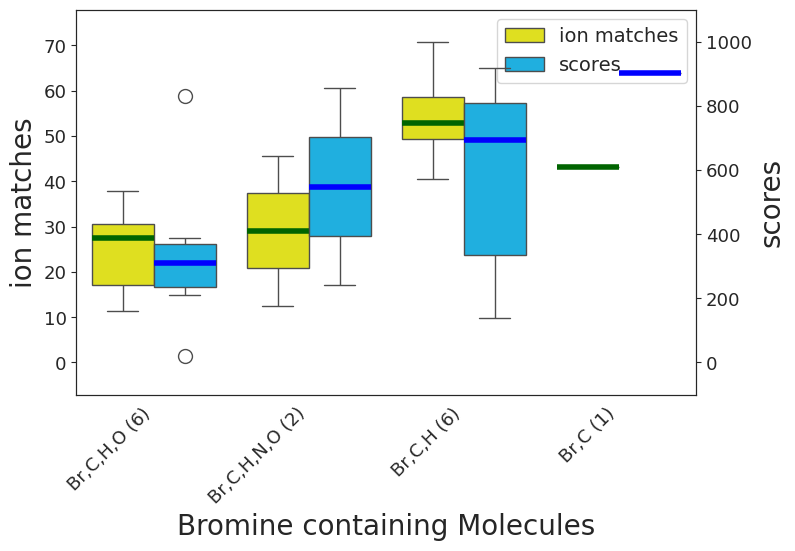

In [21]:
mdf_comp_brominated = mdf_comp[mdf_comp['composition'].str.contains('Br') & ~mdf_comp['composition'].str.contains('Cl|F|I|P|S|Si')]
create_plot(mdf_comp_brominated, "composition", "Bromine containing Molecules", normalized_matches=False).show()